## Topic modelling

В этой тетрадке показываются основные приёмы работы с LDA, варианты подбора параметров и способы визуализации. При необходимости можно будет сделать отдельную тетрадку с пояснением механизма работы алгоритма.

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from termcolor import colored
import glob
from nltk.stem.wordnet import WordNetLemmatizer

import pyLDAvis.gensim
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore

import matplotlib.pyplot as plt
%matplotlib inline

import tm_functions

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Фиксирование рандома и прочее
np.random.seed(42)
lemma = WordNetLemmatizer()
ru_stop = stopwords.words('russian')

### Обработка текста

Для этой тетрадки использую только 1 датасет. Но по факту работа с несколькими ничем не отличается, кроме объёма данных

*UPD:* Взял 5 датасетов

In [12]:
data = pd.DataFrame()
for df in glob.glob('data/*.txt.gz'):
    data = data.append(pd.read_csv(df, sep='\t', encoding='utf-8', header=None))
    
data.columns = ['id', 'url', 'title', 'text']
# есть немного дубликатов
data = data.drop_duplicates('url')

In [15]:
print(f'{data.shape[0]} строк')

70726 строк


Для начала токенизируем тексты.

In [16]:
%%time
data.loc[:, 'cleaned_text'] = data['text'].apply(lambda x: tm_functions.text_to_words(x, return_tokenized=False, lemmatizer=lemma, stop_words=ru_stop))

Wall time: 1min 11s


In [17]:
%%time
data.loc[:, 'tokenized_text'] = data['text'].apply(lambda x: tm_functions.text_to_words(x, lemmatizer=lemma, stop_words=ru_stop, return_tokenized=True))

Wall time: 1min 7s


### LDA

Для работы с LDA нам нужно подготовить 2 объекта:
* словарь, в котором каждому слову присваивается уникальный id;
* список преобразованных текстов;

Первое по факту - список уникальных слов и их id, второе - Bag of Words. Так что при желании можно сделать вручную.

In [18]:
%%time
dictionary = corpora.Dictionary(data['tokenized_text'].values)

Wall time: 16.9 s


In [19]:
%%time
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data['tokenized_text'].values]

Wall time: 12.5 s


Теперь создадим саму модель. В неё подаём созданные нами объекты, количество топиков и passes - сколько раз модель пройдётся по данным. Можно передавать и другие параметры, но это в следующий раз.

In [20]:
%%time
ldamodel = LdaModel(doc_term_matrix, num_topics=3, id2word = dictionary, passes=10)

Wall time: 6min 27s


Оказывается есть версия, которая параллелится. Рекомендуется ставить количество на 1 меньшее количества реальных ядер. Чем больше объём текста, тем больше разница. При использовании одного датасета разница была процентов 20, а здесь почти в 2 раза.

In [21]:
%%time
ldamodel_fast = LdaMulticore(doc_term_matrix, num_topics=3, id2word = dictionary, passes=10, workers=5)

Wall time: 3min 29s


Один из лучших инструментов для визуализации LDA - pyLDAvis.

In [22]:
%%time
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(ldamodel_fast, doc_term_matrix, dictionary, mds='tsne')

Wall time: 37.3 s


Можно поиграться с визуализацией, советую подвигать слайдер в правом верхнем углу.

In [23]:
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.173688  0.027620       1        1  50.594604
2      0.048673 -0.108067       2        1  30.647060
0      0.125015  0.080448       3        1  18.758337, topic_info=       Category          Freq        Term         Total  loglift  logprob
term                                                                     
120     Default  97542.000000         это  97542.000000  30.0000  30.0000
4754    Default  20778.000000     украины  20778.000000  29.0000  29.0000
1317    Default  23968.000000       очень  23968.000000  28.0000  28.0000
47647   Default  20937.000000          рф  20937.000000  27.0000  27.0000
2820    Default  22240.000000     новости  22240.000000  26.0000  26.0000
1462    Default  43703.000000       также  43703.000000  25.0000  25.0000
8305    Default  15797.000000      заявил  15797.000000  24.0000  24.0000
737     Default  12259.000000        люди  12259.000000  23.0000  23.0000
435     Default  14111.000000      просто  14111.000000  22.0000  22.0000
2124    Default  14359.000000        фото  14359.000000  21.0000  21.0000
45      Default  22916.000000         лет  22916.000000  20.0000  20.0000
7280    Default  15930.000000       ранее  15930.000000  19.0000  19.0000
1158    Default  10895.000000       жизни  10895.000000  18.0000  18.0000
11659   Default  13904.000000    сообщает  13904.000000  17.0000  17.0000
7295    Default  20615.000000         сша  20615.000000  16.0000  16.0000
1106    Default   8159.000000      вообще   8159.000000  15.0000  15.0000
26436   Default  10076.000000      данным  10076.000000  14.0000  14.0000
773     Default   9170.000000      почему   9170.000000  13.0000  13.0000
9055    Default  22096.000000     читайте  22096.000000  12.0000  12.0000
8       Default  10250.000000       глава  10250.000000  11.0000  11.0000
1903    Default   4211.000000       фильм   4211.000000  10.0000  10.0000
2241    Default   3820.000000      фильма   3820.000000   9.0000   9.0000
318     Default  10774.000000         нам  10774.000000   8.0000   8.0000
602     Default  25331.000000        году  25331.000000   7.0000   7.0000
2207    Default  12440.000000       людей  12440.000000   6.0000   6.0000
4727    Default   6156.000000   порошенко   6156.000000   5.0000   5.0000
670     Default  51420.000000      россии  51420.000000   4.0000   4.0000
10956   Default  11018.000000   президент  11018.000000   3.0000   3.0000
4730    Default  10602.000000  президента  10602.000000   2.0000   2.0000
7236    Default   9148.000000         суд   9148.000000   1.0000   1.0000
...         ...           ...         ...           ...      ...      ...
1829     Topic3   2666.612061       самых   4898.772461   1.0654  -6.9468
1657     Topic3   2262.400635        кино   4421.465820   1.0035  -7.1112
602      Topic3   6615.980957        году  25331.162109   0.3310  -6.0382
623      Topic3   5997.524414     который  25599.339844   0.2223  -6.1363
1286     Topic3   2664.616211       новый   6377.114258   0.8009  -6.9476
2463     Topic3   4441.499023           е  16488.787109   0.3618  -6.4367
739      Topic3   2705.831787        мира   6898.298828   0.7377  -6.9322
3909     Topic3   1922.419556       видео   3765.280762   1.0013  -7.2741
3        Topic3   5829.105469       время  33531.046875  -0.0761  -6.1648
307      Topic3   2637.999512       место   7524.783691   0.6254  -6.9576
120      Topic3   9001.291016         это  97542.156250  -0.7094  -5.7303
1726     Topic3   3441.510254       нашли  13583.812500   0.3006  -6.6917
3304     Topic3   2647.391113        стал   8140.320801   0.5503  -6.9541
1462     Topic3   5718.401855       также  43703.250000  -0.3602  -6.1840
9        Topic3   5766.701660        года  45208.234375  -0.3856  -6.1755
45       Topic3   4165.506836         лет  22916.914062  -0.0315  -6.5008
747      Topic3   3134.165771   несколько  13808.404297   0.1

Нам бы как-то оценить качество модели. Попробуем 2 метрики.

In [24]:
%%time
perplexity = ldamodel_fast.log_perplexity(doc_term_matrix)
coherence_model_lda = CoherenceModel(model=ldamodel_fast, texts=data['tokenized_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

Wall time: 1min 40s


In [25]:
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -10.169966583416185
Coherence Score: 0.36204112919448456


Попробуем сделать большое количество топиков.

In [30]:
%%time
start = 2
limit = 33
step = 5
model_list, coherence_values = tm_functions.compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix,
                                                                     texts=data['tokenized_text'].values,
                                                                     start=2, limit=limit, step=step, use_multicore=False)

Num topics: 2. Wed Oct  3 06:19:25 2018
Num topics: 7. Wed Oct  3 06:25:48 2018
Num topics: 12. Wed Oct  3 06:35:15 2018
Num topics: 17. Wed Oct  3 06:46:48 2018
Num topics: 22. Wed Oct  3 07:01:35 2018
Num topics: 27. Wed Oct  3 07:20:05 2018
Num topics: 32. Wed Oct  3 07:42:13 2018
Wall time: 1h 48min 10s


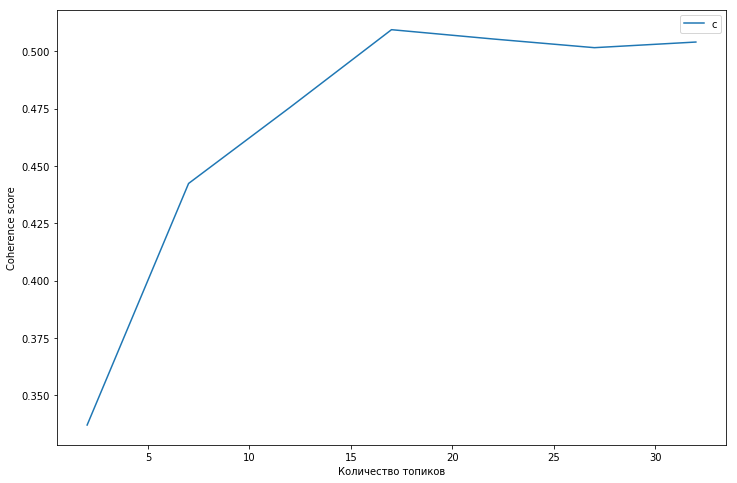

In [31]:
plt.figure(figsize=(12, 8))
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество топиков")
plt.ylabel("Coherence score")
plt.legend("coherence_values", loc='best')
plt.show()

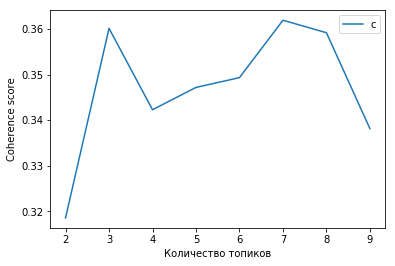

In [20]:
# Старая версия
x = range(2, 10, 1)
plt.plot(x, coherence_values)
plt.xlabel("Количество топиков")
plt.ylabel("Coherence score")
plt.legend("coherence_values", loc='best')
plt.show()

In [33]:
%%time
ldamodel_fast = LdaMulticore(doc_term_matrix, num_topics=10, id2word = dictionary, passes=10, workers=5)

Wall time: 4min 34s


In [34]:
%%time
ldamodel_fast = LdaMulticore(doc_term_matrix, num_topics=10, id2word = dictionary, passes=10, workers=5, chunksize=70726)

Wall time: 24min 18s


Хм, я надеялся, что увеличение значения `chunksize` ускорит работу модели, но увы.

Ладно, поработаем с лучшей моделью из отбранных.

In [36]:
best_model = model_list[np.argmax(coherence_values)]
best_model.num_topics

17

In [37]:
%%time
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(best_model, doc_term_matrix, dictionary, mds='tsne')

Wall time: 1min 21s


In [38]:
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.147921 -0.169674       1        1  20.098631
5      0.189133  0.055234       2        1  10.430760
7      0.200591  0.156276       3        1  10.377020
3      0.206105  0.066450       4        1   9.900330
4      0.142851  0.015516       5        1   9.030067
16     0.011993 -0.281245       6        1   7.913833
9      0.128158  0.100269       7        1   5.458731
13    -0.013350 -0.004469       8        1   4.297646
8     -0.064136 -0.127230       9        1   4.109480
1      0.003562  0.072679      10        1   3.390818
12     0.012617  0.044683      11        1   3.330568
0     -0.117064 -0.151004      12        1   3.302489
2     -0.069524 -0.149529      13        1   3.039752
6     -0.126009  0.023406      14        1   1.899631
10    -0.240043  0.096836      15        1   1.251241
15    -0.189800  0.094776      16        1   1.167724
11    -0.223006  0.157027      17        1   1.001271, topic_info=       Category           Freq            Term          Total  loglift  \
term                                                                     
120     Default  106563.000000             это  106563.000000  30.0000   
670     Default   55717.000000          россии   55717.000000  29.0000   
4754    Default   21684.000000         украины   21684.000000  28.0000   
2124    Default   25812.000000            фото   25812.000000  27.0000   
1317    Default   28490.000000           очень   28490.000000  26.0000   
47647   Default   27137.000000              рф   27137.000000  25.0000   
7295    Default   19370.000000             сша   19370.000000  24.0000   
1827    Default   19990.000000          рублей   19990.000000  23.0000   
108962  Default    6497.000000        выделите    6497.000000  22.0000   
49627   Default   13937.000000           путин   13937.000000  21.0000   
7280    Default   17753.000000           ранее   17753.000000  20.0000   
7403    Default   11450.000000         украине   11450.000000  19.0000   
8305    Default   17936.000000          заявил   17936.000000  18.0000   
5276    Default   13271.000000          москвы   13271.000000  17.0000   
9       Default   39793.000000            года   39793.000000  16.0000   
13581   Default   13039.000000         области   13039.000000  15.0000   
1462    Default   36137.000000           также   36137.000000  14.0000   
647     Default   13845.000000          ноября   13845.000000  13.0000   
267     Default    9035.000000        компании    9035.000000  12.0000   
11389   Default   11911.000000             сми   11911.000000  11.0000   
602     Default   24191.000000            году   24191.000000  10.0000   
10956   Default   14149.000000       президент   14149.000000   9.0000   
10611   Default   14719.000000          россия   14719.000000   8.0000   
739     Default    5673.000000            мира    5673.000000   7.0000   
206     Default   12647.000000            дело   12647.000000   6.0000   
72729   Default    5430.000000           сирии    5430.000000   5.0000   
4730    Default   13301.000000      президента   13301.000000   4.0000   
435     Default   15155.000000          просто   15155.000000   3.0000   
575     Default   22091.000000         человек   22091.000000   2.0000   
9055    Default   16465.000000         читайте   16465.000000   1.0000   
...         ...            ...             ...            ...      ...   
262     Topic17     421.722778             ким     422.763062   4.6014   
39725   Topic17     393.620361       футболист     394.660675   4.6013   
48839   Topic17     357.729095           папой     358.769409   4.6010   
53488   Topic17     324.553406        стрельбы     325.593719   4.6007   
46821   Topic17     323.139923        эпидемии     324.180237   4.6007   
43388   Topic17     318.738220           кореи     319.778503   4.6006   
59329   Topic17     314.896576       пугачево

Какие-то топики можно довольно легко понять!

А теперь достанем самые популярные топики из каждого текста.

In [62]:
df_topic_sents_keywords = tm_functions.format_topics_sentences(ldamodel=best_model, corpus=doc_term_matrix, texts=data['tokenized_text'].values)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(best_model.num_topics)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4235,,"[пока, остальные, сгорали, нетерпения, ожидани..."
1,1,16.0,0.4680,"это, время","[лето, похоже, закончилось, вернее, спала, нев..."
2,2,3.0,0.2599,"года, россии, ноября","[британская, инди, рок, группа, временем, пере..."
3,3,0.0,0.4009,,"[птицы, бабочки, почему, люди, летают, птицы, ..."
4,4,0.0,0.6665,"девушки, своей","[уроки, оп, арта, саши, лусс, сентябрьском, об..."
5,5,6.0,0.4786,компания,"[компания, представила, новинку, рынке, звуков..."
6,6,8.0,0.4727,"году, режиссер","[режиссер, гарри, поттера, вернет, магический,..."
7,7,14.0,0.3644,"это, которые, очень, просто, поэтому, который,...","[елена, стафьева, рассуждает, почему, естестве..."
8,8,13.0,0.2791,"москве, м, столицы, город","[кому, надоело, проводить, выходные, кровати, ..."
9,9,10.0,0.5166,запах,"[выходит, вторая, версия, аромата, итальянские..."


А теперь для каждого топика поищем тексты, где доля этого топика максимальна. Это может помочь упростить их интерпретацию

In [47]:
# Найдём индексы строк, в которых содержатся максимальные доли каждого из топиков
top_indices = df_topic_sents_keywords.groupby('Dominant_Topic')['Perc_Contribution'].nlargest(1).reset_index()['level_1']

In [48]:
df_topic_sents_keywords[df_topic_sents_keywords.index.isin(top_indices)]

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
1288,6.0,0.8519,модели,"[современная, механика, турбийон, часовые, усл..."
5107,10.0,0.7817,"е, кожи, масло","[любое, другое, время, года, летом, коже, треб..."
7042,0.0,0.9608,,"[обзор, весна, лето, весна, лето, париже, прод..."
8120,7.0,0.9243,"украины, россии, путин, украине, новости","[договорятся, путин, порошенко, прямой, эфир, ..."
12519,14.0,0.8824,,"[олег, тюрпенко, особенно, поддерживать, уголь..."
12825,11.0,0.8118,эбола,"[американец, заразился, вирусом, эбола]"
13542,1.0,0.8824,"сирии, сша","[ввс, сша, снова, ударили, позициям, иг, сирии]"
14494,16.0,0.8655,,"[кузбасский, вор, украл, баню, продал, соседу]"
19147,8.0,0.8991,"фильм, актер, роль, фильме, года","[российский, фильм, левиафан, режиссера, андре..."
20884,3.0,0.8909,,"[главой, вновь, станет, основатель, экс, мэр, ..."


Ещё для каждого топика можно посмотреть количество документов.

In [49]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
condition = df_topic_sents_keywords.index.isin(top_indices)
topic_num_keywords = df_topic_sents_keywords[condition][['Dominant_Topic', 'Topic_Keywords']].reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,6.0,модели,3754,0.0531
1,10.0,"е, кожи, масло",1864,0.0264
2,0.0,,810,0.0115
3,7.0,"украины, россии, путин, украине, новости",6207,0.0878
4,14.0,,11328,0.1602
5,11.0,эбола,9048,0.1279
6,1.0,"сирии, сша",968,0.0137
7,16.0,,10008,0.1415
8,8.0,"фильм, актер, роль, фильме, года",3022,0.0427
9,3.0,,2440,0.0345


Ну и попробуем раскрасить слова в тексте в цвета по топикам. Возьмём случайный текст